# __Magnetization Transfer saturation Imaging (Siemens 3T)__
#### __Last updated on:__ 02/04/2020
#### __Author: Rakshit Dadarwal__

### __Import libraries__

In [38]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom as dicom
from natsort import natsorted

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

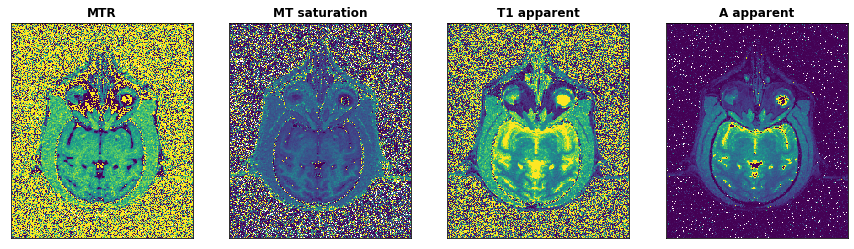

In [37]:
# load MRI measurements scan list csv file
csv_path = "/home/rdadarwal/macaque_aging/RAKSHIT_data_analysis_TP1/"
csv_file = 'ScanList_MT_test.csv'
csv_filepath = os.path.join(csv_path,csv_file)
Siemens_meas = pd.read_csv(csv_filepath,na_values='scalar')

# T1, MT, and PD measurement number
t1scan = (Siemens_meas['T1']).astype(int)
mtscan = (Siemens_meas['MT']).astype(int)
pdscan = (Siemens_meas['PD']).astype(int)
# macaque measurement number
mac_nr = (Siemens_meas['MR_Number']).astype(int)

for mac in mac_nr.index:
    if os.path.exists("/mnt/scanner/siemens/macaque/mac_0"+str(mac_nr[mac])+"/dicom"):
        acq_path = "/mnt/scanner/siemens/macaque/mac_0"+str(mac_nr[mac])+"/dicom"

        if os.path.exists(acq_path):
            # Study folder path for each subject
            data_path = csv_path+'MT/'+'mac_0'+str(mac_nr[mac])+'/'
            
            scan_nr = [mtscan[mac],pdscan[mac],t1scan[mac]]
            for idx, scan in enumerate (scan_nr):
                if scan < 10:
                    dicom_nr = 'M-0'+str(mac_nr[mac])+'-000'+str(scan)+'-0'
                else:
                    dicom_nr = 'M-0'+str(mac_nr[mac])+'-00'+str(scan)+'-0'      
                
                # check existence of empty directory in the study folder
                if not os.path.exists(data_path+str(scan)):
                    # make empty directory
                    os.mkdir(os.path.join(data_path,str(scan)))

                #============================
                # Change directory
                os.chdir(data_path)

                # copy dicom files into the save path folder
                for file in glob.glob(acq_path+'/{0}*'.format(dicom_nr)):
                    shutil.copy(file, data_path+'/'+str(scan)+'/')
            
            #======================================================================================
            # read dicom files with header
            
            def read_dicom(path):
                lstFiles = [] # create an empty list
                for ddir, subdirList, fileList in os.walk(path):
                    for filename in natsorted(fileList): # sorted filenames
                        if ".dcm" in filename.lower(): # check weather the file's DICOM
                            lstFiles.append(os.path.join(ddir,filename)) 

                # Get ref file
                Ref = dicom.read_file(lstFiles[0])
                read_dicom.Ref = Ref
                
                # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
                ConstPixelDims = (int(Ref.Rows), int(Ref.Columns), len(lstFiles))
                read_dicom.ConstPixelDims = ConstPixelDims

                # Load acquisition parameters
                FA = np.deg2rad(Ref.FlipAngle); TE = Ref.EchoTime; NA = Ref.NumberOfAverages; TR = Ref.RepetitionTime

                # Load spacing values (in mm)
                ConstPixelSpacing = (float(Ref.PixelSpacing[0]), 
                                     float(Ref.PixelSpacing[1]), 
                                     float(Ref.SliceThickness))
                 # The array is sized based on 'ConstPixelDims'
                dicom_data = np.zeros(ConstPixelDims, dtype=Ref.pixel_array.dtype)

                # loop through all the DICOM files
                for filename in lstFiles:
                    # read the file
                    ds = dicom.read_file(filename)
                    # store the raw image data
                    dicom_data[:, :, lstFiles.index(filename)] = ds.pixel_array 
                
                return dicom_data, FA, TE, NA, TR 
            
            # T1, MT, and PD dicom files with their hdr information
            T1dicom, FAt1, TEt1, NAt1, TRt1 = read_dicom(data_path+str(t1scan[mac]))
            MTdicom, FAmt, TEmt, NAmt, TRmt = read_dicom(data_path+str(mtscan[mac]))
            PDdicom, FApd, TEpd, NApd, TRpd = read_dicom(data_path+str(pdscan[mac]))
                
            #==========================================================================================
            # MTR estimation
            
            # The array is sized based on 'ConstPixelDims'
            MTR = np.zeros(read_dicom.ConstPixelDims, dtype=read_dicom.Ref.pixel_array.dtype)
            
            # MTR estimation
            MTR = np.divide(np.subtract(PDdicom, MTdicom), PDdicom) * 100
            
            #==========================================================================================
            # MT saturation parameter estimation       
            
            T1app = np.zeros(read_dicom.ConstPixelDims, dtype=read_dicom.Ref.pixel_array.dtype)
            Aapp = np.zeros(read_dicom.ConstPixelDims, dtype=read_dicom.Ref.pixel_array.dtype)
            MTsat = np.zeros(read_dicom.ConstPixelDims, dtype=read_dicom.Ref.pixel_array.dtype)
            # apparent T1, apparent A, and MT saturation estimation
            T1app = np.divide(2*((PDdicom/FApd)-(T1dicom/FAt1)),(T1dicom*FAt1/TRt1 - PDdicom*FApd/TRpd))
            Aapp = np.divide(np.multiply(T1dicom,PDdicom),PDdicom*FApd - T1dicom*FAt1)*(FApd/FAt1 - (FAt1/FApd))
            MTsat = np.divide(np.divide(Aapp*FAmt, MTdicom -1),T1app*TRmt - (FAmt**2)/2)
                                   
            #==========================================================================================
            # plot paramter maps
            fig, [ax0, ax1, ax2, ax3] = plt.subplots(1,4,figsize=(15,8),subplot_kw={'xticks': [], 'yticks': []})
            ax0.imshow(MTR[:,:,60], vmin=20, vmax=70); ax0.set_title('MTR',fontweight='bold')
            ax1.imshow(MTsat[:,:,60], vmin=3E-5, vmax=3E-4); ax1.set_title('MT saturation',fontweight='bold')
            ax2.imshow(T1app[:,:,60], vmin=100, vmax=2000); ax2.set_title('T1 apparent',fontweight='bold')
            ax3.imshow(Aapp[:,:,60], vmin=100, vmax=9000); ax3.set_title('A apparent',fontweight='bold')